# Pipeline et modèle

In [119]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder,PolynomialFeatures,FunctionTransformer,StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import GridSearchCV,learning_curve
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)

import pickle

In [120]:
df = pd.read_csv("../data/AmesHousing.csv")
df_anormal = df[df["Sale Condition"]=="Abnorml"]
df = df[df["Sale Condition"]!="Abnorml"]
ngbd=list(df.Neighborhood.value_counts()[df.Neighborhood.value_counts()>1].index)
df=df.loc[df['Neighborhood'].isin(ngbd)]

Il ne faut selectionner que 10 features, on supprime Neighborhood qui est trop complexe à traiter, ainsi que bsmt Qual et garage Finish qui sont trop proches d'autres variables

In [121]:
numeric_features = ["Year Built", "1st Flr SF", "Gr Liv Area", "Garage Area", "Overall Qual", "Full Bath"]
ordinal_features = [ "Exter Qual",  "Kitchen Qual"]
cat_feature = ["Foundation","Neighborhood"]
all_col = numeric_features.copy()
all_col.extend(ordinal_features)
all_col.extend(cat_feature)

X = df[all_col]
y = np.log(df[["SalePrice"]])

X["Garage Area"].fillna(0, inplace=True)
X_anormal = df_anormal[all_col]
y_anormal = np.log(df_anormal[["SalePrice"]])



/tmp/ipykernel_49814/3878609146.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["Garage Area"].fillna(0, inplace=True)


In [122]:
X.columns 

Index(['Year Built', '1st Flr SF', 'Gr Liv Area', 'Garage Area',
       'Overall Qual', 'Full Bath', 'Exter Qual', 'Kitchen Qual', 'Foundation',
       'Neighborhood'],
      dtype='object')

In [123]:
X.columns = ['Year_Built',  '1st_Flr_SF', 'Gr_Liv_Area','Garage_Area', 'Overall_Qual', 'Full_Bath', 'Exter_Qual',
       'Kitchen_Qual', "Foundation",'Neighborhood']
X_anormal.columns=['Year_Built',  '1st_Flr_SF', 'Gr_Liv_Area','Garage_Area', 'Overall_Qual', 'Full_Bath', 'Exter_Qual',
       'Kitchen_Qual', "Foundation",'Neighborhood']

In [124]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=X["Neighborhood"] ,random_state=42)

In [125]:
numeric_transformer = SimpleImputer()

exter_cat = [ 'Po', 'Fa','TA', 'Gd','Ex']
kitchen_cat = [ 'Po', 'Fa','TA', 'Gd',"Ex"]



ordinal_transformer = OrdinalEncoder(categories=[exter_cat, kitchen_cat])

categorical_transformer = OneHotEncoder()

In [126]:
standar_transformer = StandardScaler()
poly_transformer = PolynomialFeatures(2)

numeric_imputer = SimpleImputer() 
numeric_transformer = Pipeline([
    ('imputer', numeric_imputer),
    ('standar', standar_transformer),   
])
numeric_transformer_poly = Pipeline([
    ('imputer', numeric_imputer),
    ('standar', standar_transformer),
    ('poly', poly_transformer),
    
])

exter_cat = [ 'Po', 'Fa','TA', 'Gd','Ex']
kitchen_cat = [ 'Po', 'Fa','TA', 'Gd',"Ex"]

ordinal_transformer = OrdinalEncoder(categories=[exter_cat, kitchen_cat])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [127]:
numeric_features = [ "Gr_Liv_Area",  "1st_Flr_SF", "Overall_Qual","Garage_Area","Year_Built", "Full_Bath"]
numeric_features_poly = []

ordinal_features = [ "Exter_Qual",  "Kitchen_Qual"]
cat_feature = [ "Foundation","Neighborhood"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('num_poly', numeric_transformer_poly, numeric_features_poly),
        ('ord', ordinal_transformer, ordinal_features),
        ('cat', categorical_transformer, cat_feature),
    ]
)



In [128]:
reg = Lasso(alpha=0.1,random_state=42)

In [163]:
pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('reg', reg)
])

parameters = {"reg__alpha":np.linspace(0.000001,0.0001,100)}
grid_src = GridSearchCV(estimator=pipe, param_grid=parameters,scoring=mean_absolute_error,cv=5,n_jobs=-1)
grid_src.fit(X_train, y_train)

pipe.set_params(**grid_src.best_params_)
print(grid_src.best_params_)
best=grid_src.best_params_


/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.774524402245246, tolerance: 0.027027531749205184
  model = cd_fast.sparse_enet_coordinate_descent(
/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:824: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 813, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/utils/_param_validation.py", line 189, in wrapper
    params = func_sig.bind(*args, **kwargs)
  File "/home/apprenant/miniconda3/envs/e2/lib/python3.9/ins

{'reg__alpha': 1e-06}


/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.204479177049375, tolerance: 0.03409586812814933
  model = cd_fast.sparse_enet_coordinate_descent(


In [164]:
pipe.fit(X_train, y_train)
pipe.score(X_test,y_test)

predict_train  = pipe.predict(X_train)
predict_test  = pipe.predict(X_test)
predict_anormal  = pipe.predict(X_anormal)
# Root Mean Squared Error on train and test date
print('MAE on train data: ', mean_absolute_error(np.exp(y_train), np.exp(predict_train)))
print('MAE on test data: ',  mean_absolute_error(np.exp(y_test), np.exp(predict_test)))
print('MAE on anormal data: ',  mean_absolute_error(np.exp(y_anormal), np.exp(predict_anormal)))

MAE on train data:  18019.6778904965
MAE on test data:  18384.87459083827
MAE on anormal data:  24683.0110304895


/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7.204479177049375, tolerance: 0.03409586812814933
  model = cd_fast.sparse_enet_coordinate_descent(


In [165]:
print(pipe.score(X_train,y_train))
print(pipe.score(X_test,y_test))
print(pipe.score(X_anormal,y_anormal))

0.8700673876678904
0.8708767847284691
0.6315960767561388


In [166]:
filename = '../real_estate_app/main_app/static/models/finalized_model.pkl'
pickle.dump(pipe, open(filename, 'wb'))

In [167]:
pipe[:-1].get_feature_names_out()

array(['num__Gr_Liv_Area', 'num__1st_Flr_SF', 'num__Overall_Qual',
       'num__Garage_Area', 'num__Year_Built', 'num__Full_Bath',
       'ord__Exter_Qual', 'ord__Kitchen_Qual', 'cat__Foundation_BrkTil',
       'cat__Foundation_CBlock', 'cat__Foundation_PConc',
       'cat__Foundation_Slab', 'cat__Foundation_Stone',
       'cat__Foundation_Wood', 'cat__Neighborhood_Blmngtn',
       'cat__Neighborhood_Blueste', 'cat__Neighborhood_BrDale',
       'cat__Neighborhood_BrkSide', 'cat__Neighborhood_ClearCr',
       'cat__Neighborhood_CollgCr', 'cat__Neighborhood_Crawfor',
       'cat__Neighborhood_Edwards', 'cat__Neighborhood_Gilbert',
       'cat__Neighborhood_Greens', 'cat__Neighborhood_GrnHill',
       'cat__Neighborhood_IDOTRR', 'cat__Neighborhood_MeadowV',
       'cat__Neighborhood_Mitchel', 'cat__Neighborhood_NAmes',
       'cat__Neighborhood_NPkVill', 'cat__Neighborhood_NWAmes',
       'cat__Neighborhood_NoRidge', 'cat__Neighborhood_NridgHt',
       'cat__Neighborhood_OldTown', 'cat__N

In [168]:
pipe[-1].coef_

array([ 1.06461226e-01,  2.51157565e-02,  1.19700953e-01,  4.31027574e-02,
        4.73779359e-02,  2.64664051e-04,  1.58912185e-02,  6.06162940e-02,
       -3.47722481e-02,  2.70234700e-02,  1.48156915e-02, -1.58149073e-01,
       -6.63591924e-02, -4.84847534e-02, -5.13538714e-02, -1.63633087e-01,
       -2.71121753e-01, -2.59423985e-02,  1.39329501e-01,  5.23557963e-03,
        1.70045442e-01, -1.15021817e-01,  9.10738296e-03, -5.32205244e-02,
        3.71667157e-01, -1.45601567e-01, -2.35859066e-01,  1.36533609e-02,
       -1.51737607e-02, -1.08258899e-01,  4.15676585e-03,  1.15491152e-01,
        1.01739915e-01, -9.99829980e-02, -6.17138977e-02, -1.41042907e-02,
       -4.56702867e-02,  2.88217996e-02,  1.45282584e-01,  1.10581217e-01,
        9.16085446e-02])

In [169]:
print(f"La valeur de l'intercept est : {pipe[-1].intercept_[0]}")

La valeur de l'intercept est : 11.840154288677251


In [170]:
pd.DataFrame(dict(zip(pipe[:-1].get_feature_names_out(), pipe[-1].coef_)),index=["Coef"]).T.sort_values(by="Coef",ascending=False)

,Coef
cat__Neighborhood_GrnHill,0.371667
cat__Neighborhood_Crawfor,0.170045
cat__Neighborhood_StoneBr,0.145283
cat__Neighborhood_ClearCr,0.139330
num__Overall_Qual,0.119701
cat__Neighborhood_NoRidge,0.115491
cat__Neighborhood_Timber,0.110581
num__Gr_Liv_Area,0.106461
cat__Neighborhood_NridgHt,0.101740
cat__Neighborhood_Veenker,0.091609


In [171]:

dico = {'Year_Built': 2015, 'Foundation': "CBlock", '1st_Flr_SF': 30, 'Gr_Liv_Area': 100, 'Garage_Area': 1, 'Overall_Qual': 1, 'Full_Bath': 1, 'Exter_Qual': 'Po', 'Kitchen_Qual': 'Po', 'Neighborhood': 'Blmngtn'}

In [172]:
np.exp(pipe.predict(pd.DataFrame(dico,index=[0])))

array([58738.82815219])

/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.24032692001975464, tolerance: 0.002902739982985054
  model = cd_fast.sparse_enet_coordinate_descent(
/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.353103794572339, tolerance: 0.0038646324331923624
  model = cd_fast.sparse_enet_coordinate_descent(
/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.28958973258153553, tolerance: 0.0033596348685174626
  model = cd_fast.sparse_enet_coordinate_descent(
/home/apprena

/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7506795755017412, tolerance: 0.0078095994307073625
  model = cd_fast.sparse_enet_coordinate_descent(
/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3888123468114353, tolerance: 0.009262469138463923
  model = cd_fast.sparse_enet_coordinate_descent(
/home/apprenant/miniconda3/envs/e2/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3997960385420134, tolerance: 0.009919534580404558
  model = cd_fast.sparse_enet_coordinate_descent(
/home/apprenant

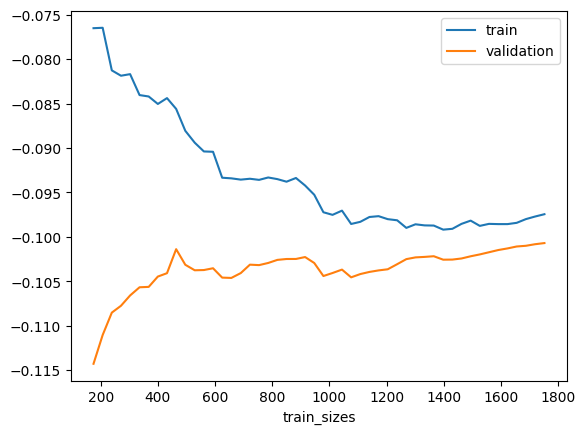

In [173]:
train_sizes, train_scores, test_scores = learning_curve(pipe,X_train,y_train,cv=5,train_sizes=np.linspace(0.1, 1.0, 50),scoring="neg_mean_absolute_error",n_jobs=-1) 
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()